# Etapas (código fonte)

1. ETL
2. EDA
3. Linear_reg
4. Modelos Gaussianos

Este notebook se refere ao item 4, o qual se caracteriza como uma continuação do projeto do Porto realizado na disciplina de PI3.

Para mais detalhes do projeto anterior (itens 1, 2 e 3), basta conferir a publicação dos próprios autores: https://semanaacademica.org.br/artigo/porto-de-santos-analise-da-movimentacao-de-carga-e-perspectivas-futuras


# Importação das bibliotecas necessárias para o projeto

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pytensor.tensor as tt

# Importação da base de dados

In [3]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('./staging/porto_ts.csv')

In [4]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [5]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [6]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [7]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)
original['data'] = pd.to_datetime(original['data'])
print(original)

      ano  mes     porto       data
0    2005    1   5027941 2005-01-01
1    2005    2   5316605 2005-02-01
2    2005    3   5899912 2005-03-01
3    2005    4   5850639 2005-04-01
4    2005    5   6826372 2005-05-01
..    ...  ...       ...        ...
211  2022    8  14626790 2022-08-01
212  2022    9  13628567 2022-09-01
213  2022   10  14435751 2022-10-01
214  2022   11  12194409 2022-11-01
215  2022   12  12096270 2022-12-01

[216 rows x 4 columns]


In [8]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0     2005-01-01
1     2005-02-01
2     2005-03-01
3     2005-04-01
4     2005-05-01
         ...    
211   2022-08-01
212   2022-09-01
213   2022-10-01
214   2022-11-01
215   2022-12-01
Name: data, Length: 216, dtype: datetime64[ns]

# Normalização dos dados

## Normalização da data


In [9]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [10]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [11]:
original_std = original[['data_std', 'porto_std', 'data']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-11-80cc1b98794f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std,data
data_std,,
0.000000,0.041554,2005-01-01
0.004651,0.068844,2005-02-01
0.009302,0.123990,2005-03-01
0.013953,0.119332,2005-04-01
0.018605,0.211578,2005-05-01
...,...,...
0.981395,0.949035,2022-08-01
0.986047,0.854662,2022-09-01
0.990698,0.930974,2022-10-01


# Não normalizados

In [12]:
original = original[['data','porto']]
original

,data,porto
0,2005-01-01,5027941
1,2005-02-01,5316605
2,2005-03-01,5899912
3,2005-04-01,5850639
4,2005-05-01,6826372
...,...,...
211,2022-08-01,14626790
212,2022-09-01,13628567
213,2022-10-01,14435751
214,2022-11-01,12194409


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [13]:
# Definindo os dados para treinamento
d = original.data.values.T               # para plotagem
# normalizado
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                               # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1                       # anos para treino /total
more_months = len(d) - n
# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')
print(more_months)

168 meses
14.0 anos
77.31 %
48


In [14]:
# Final do período de treino
original.iloc[treino_split]

data     2018-12-01 00:00:00
porto               10863015
Name: 167, dtype: object

In [15]:
# separação treino/teste
x_treino = x[:treino_split+1]
x_teste  = x[treino_split+1: ]

d_treino = d[:treino_split+1]       # para plotagem
d_teste  = d[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

In [16]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [17]:
#x_treino
x_teste
#y_treino
#y_teste

array([0.78139535, 0.78604651, 0.79069767, 0.79534884, 0.8       ,
       0.80465116, 0.80930233, 0.81395349, 0.81860465, 0.82325581,
       0.82790698, 0.83255814, 0.8372093 , 0.84186047, 0.84651163,
       0.85116279, 0.85581395, 0.86046512, 0.86511628, 0.86976744,
       0.8744186 , 0.87906977, 0.88372093, 0.88837209, 0.89302326,
       0.89767442, 0.90232558, 0.90697674, 0.91162791, 0.91627907,
       0.92093023, 0.9255814 , 0.93023256, 0.93488372, 0.93953488,
       0.94418605, 0.94883721, 0.95348837, 0.95813953, 0.9627907 ,
       0.96744186, 0.97209302, 0.97674419, 0.98139535, 0.98604651,
       0.99069767, 0.99534884, 1.        ])

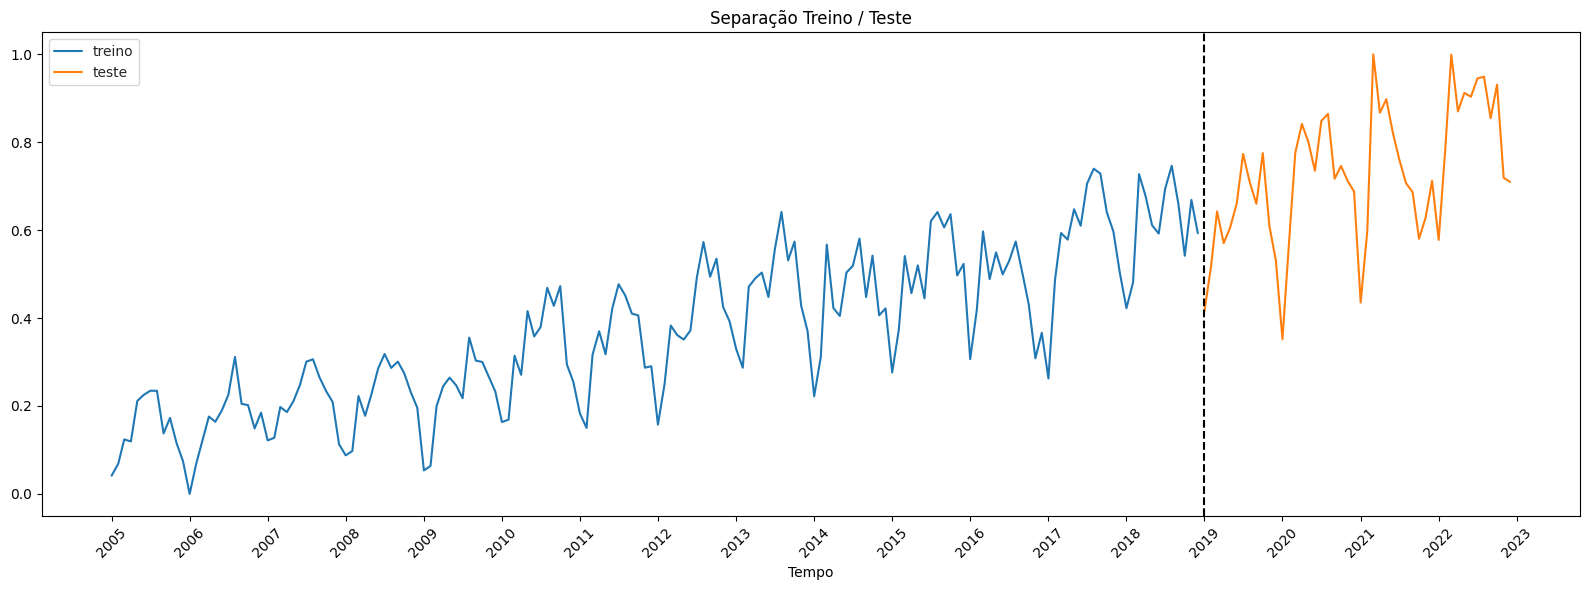

In [18]:
#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style('whitegrid')
sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)

# Adicionando linha de separação entre treino e teste
ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Definindo títulos e rótulos
ax.set(title='Separação Treino / Teste', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Modelo Phophet - FFT multiplicativo

In [155]:
# Definição da Ordem de Fourier
n_order = 10       # para season ano 10  testar 12

# Função para gerar recursos de Fourier para modelar a sazonalidade
def get_fourier(n_points,periods):

  x_f = np.linspace(0, periods, n_points) # `n_points` é o número de pontos de dados e `periods` é o número de períodos

  fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * x_f / periods * order) # `x_f` cria uma sequência linear de pontos
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
  )

  return fourier_features

In [156]:
# Definição de Coordenadas
coords = {"fourier_features": np.arange(2 * n_order)}
coords

{'fourier_features': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])}

In [185]:
# Definição do Modelo
with pm.Model(coords=coords) as prophet_p:
    X_ = pm.MutableData("X",x_treino)
    y_ = pm.MutableData("y",y_treino)
    n = X_.eval().shape[0]
    fs = get_fourier(n, 365.25)      # testar p/12: 30.4375   p/10 36.525
    fourier_f = pm.MutableData("f_f",fs.values)

    β_fourier = pm.Normal("β_fourier", mu=0.3, sigma=5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_f.T))

    # tendência linear
    a = 0.15
    b = 0.8
    trend = pm.Normal('trend', mu=a + b * X_, sigma=0.2)

    μ = trend * (1 + seasonality)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y_)

In [186]:
# Amostragem Preditiva A Priori e Visualização
with prophet_p:
  p_prior_p = pm.sample_prior_predictive()

Este código está criando um gráfico com dois subgráficos (subplots) para visualizar a distribuição preditiva a priori e as linhas de tendência a priori do modelo, utilizando as bibliotecas Matplotlib e Seaborn.

<ipython-input-187-87ec67bae66d>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=168)["likelihood"]
<ipython-input-187-87ec67bae66d>:14: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=168)["trend"] * y_treino.max(),
<ipython-input-187-87ec67bae66d>:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=168)["seasonality"]


Text(0.5, 1.0, 'Prior seasonality')

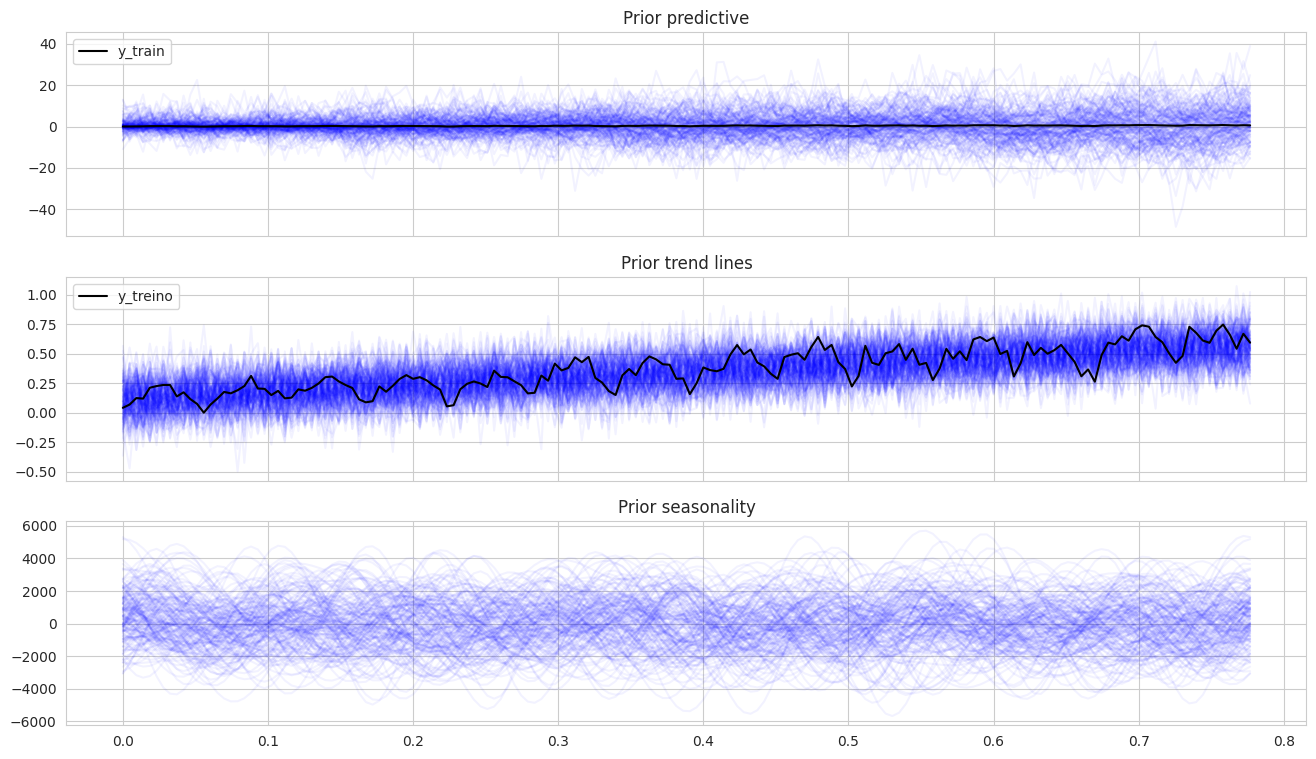

In [187]:
# Visualização dos Resultados: previsões a priori, as linhas de tendência e a sazonalidade
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16,9))
ax[0].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=168)["likelihood"]
    * y_treino.max(),
    color="blue",
    alpha=0.05
)
sns.lineplot(x=x_treino, y=y_treino, color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior", num_samples=168)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior", num_samples=168)["seasonality"]
    * 100,
    color="blue",
    alpha=0.05
)
ax[2].set_title("Prior seasonality")

In [188]:
# Ajuste do Modelo com Dados Observados
with prophet_p:
  trace_p_p = pm.sample(tune=2000)

In [189]:
pm.summary(trace_p_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_fourier[0],0.232,0.070,0.090,0.350,0.013,0.009,33.0,111.0,1.05
β_fourier[1],0.223,0.091,0.047,0.384,0.011,0.008,61.0,351.0,1.04
β_fourier[2],0.337,0.092,0.180,0.515,0.007,0.005,160.0,332.0,1.01
β_fourier[3],0.017,0.128,-0.201,0.295,0.032,0.023,17.0,88.0,1.11
β_fourier[4],0.175,0.127,-0.072,0.386,0.021,0.017,37.0,96.0,1.06
...,...,...,...,...,...,...,...,...,...
seasonality[163],-0.175,0.085,-0.333,-0.019,0.002,0.002,1161.0,1381.0,1.00
seasonality[164],-0.154,0.096,-0.323,0.021,0.003,0.002,1069.0,1268.0,1.00
seasonality[165],-0.126,0.118,-0.322,0.102,0.006,0.004,460.0,978.0,1.01
seasonality[166],-0.094,0.149,-0.348,0.193,0.011,0.007,163.0,313.0,1.01


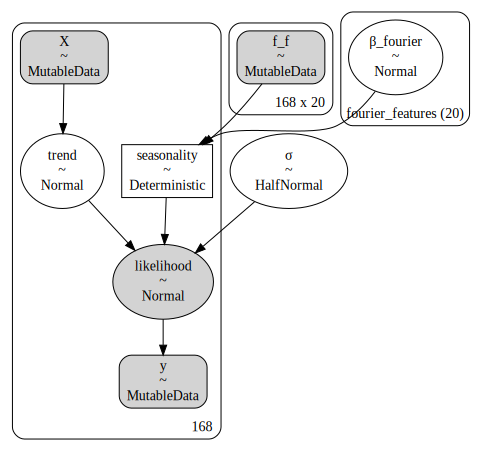

In [190]:
pm.model_to_graphviz(prophet_p)

In [191]:
# Amostragem Posterior Preditiva
with prophet_p:
  trace_post_p = pm.sample_posterior_predictive(trace_p_p)

<ipython-input-192-3b78204042e7>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

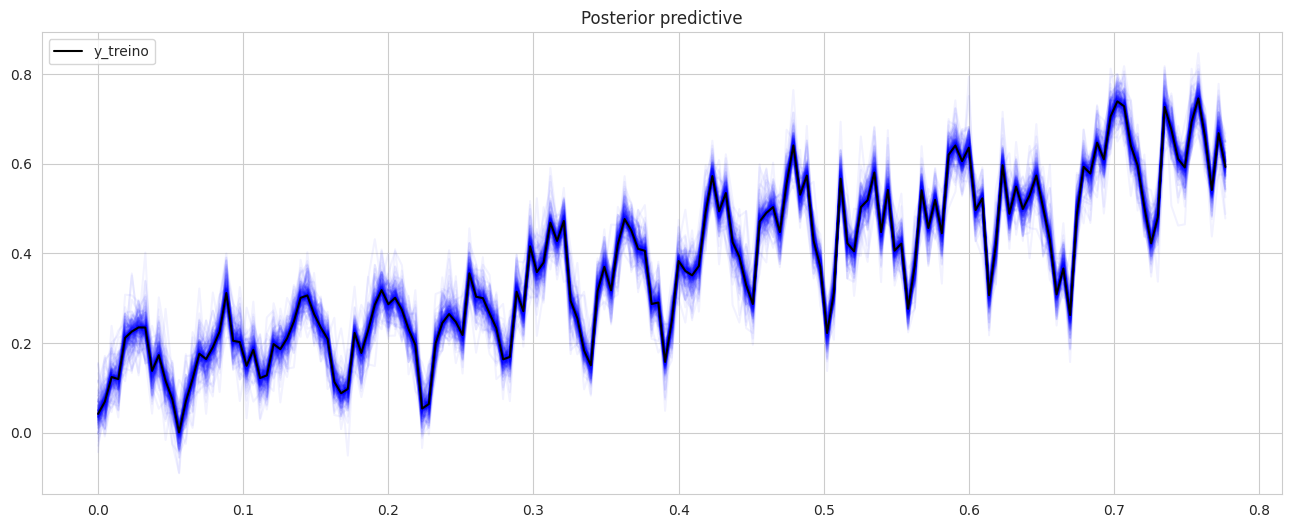

In [192]:
# Visualização das Previsões a Posteriori
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_treino,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax)
# Configurando a legenda
ax.legend(loc='upper left')
ax.set_title("Posterior predictive")

O bloco abaixo calcula e imprime o erro absoluto médio (MAE) das previsões a posteriori em relação aos dados de treinamento.

Para avaliar a acurácia das previsões (median_house_predictive) do nosso modelo em comparação com os dados de teste, calculamos uma métrica de erro comum: o Erro Médio Absoluto (MAE). Esse cálculo nos ajudam a compreender a magnitude dos erros nas previsões.

In [193]:
# Cálculo do MAE
y_pred = trace_post_p.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_treino).sum()/len(y_treino)}")

MAE: 0.0013576631775611611


In [194]:
y_pred

array([0.04323288, 0.07003033, 0.12409771, 0.11890748, 0.20973382,
       0.2244872 , 0.23351653, 0.23340106, 0.13631162, 0.16999972,
       0.11339754, 0.07364584, 0.00479706, 0.06927806, 0.11896615,
       0.17331118, 0.1623844 , 0.1896779 , 0.22578072, 0.31186349,
       0.20445169, 0.20221342, 0.14913493, 0.18410944, 0.12418136,
       0.12739952, 0.19618012, 0.18809087, 0.21076702, 0.24855101,
       0.30065748, 0.30484647, 0.26497216, 0.23387963, 0.20861225,
       0.11402444, 0.09018541, 0.09869363, 0.21901124, 0.17601112,
       0.22713364, 0.28406633, 0.31619664, 0.28610714, 0.29993055,
       0.27495185, 0.2310073 , 0.19718891, 0.05530521, 0.06842957,
       0.19917167, 0.24312359, 0.2633343 , 0.24707859, 0.21655356,
       0.35386049, 0.30194897, 0.29869275, 0.26650349, 0.23455326,
       0.16603086, 0.17018884, 0.31441446, 0.27236346, 0.41560491,
       0.35776158, 0.37825816, 0.46583745, 0.42494521, 0.46955493,
       0.29552704, 0.25594329, 0.18451393, 0.1526164 , 0.31623

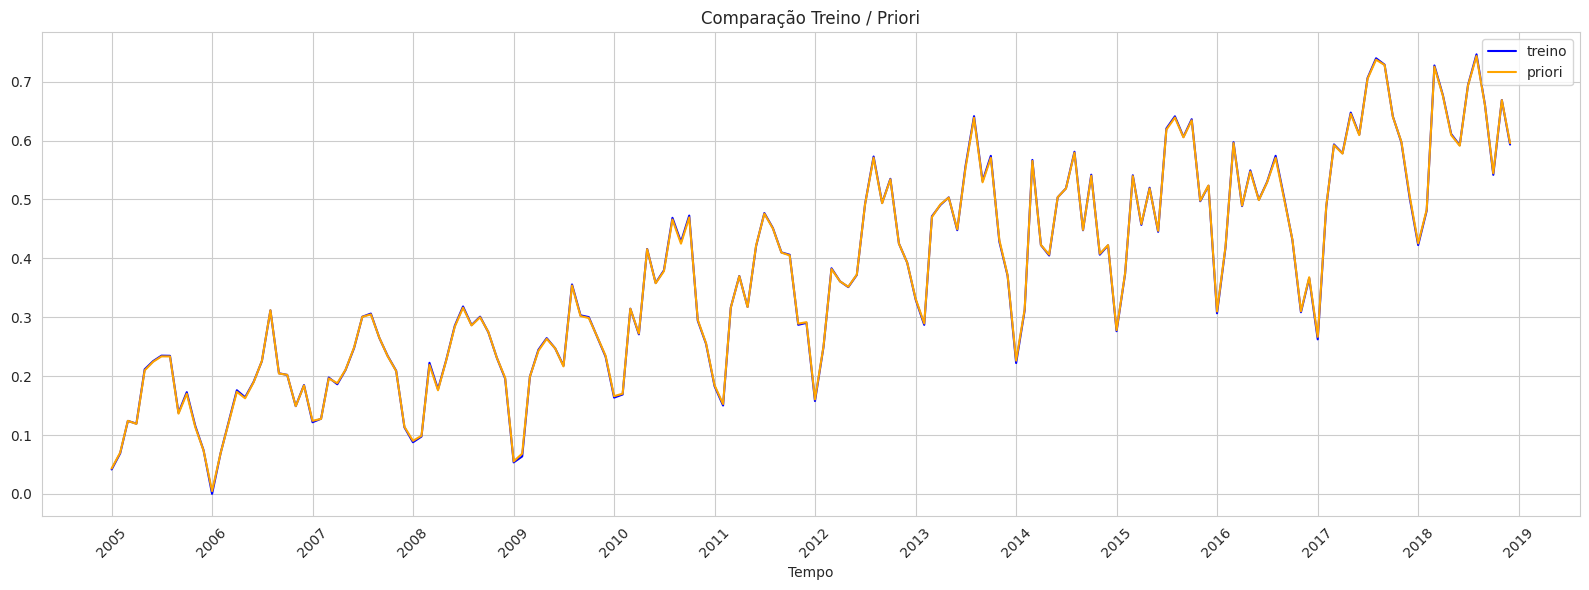

In [195]:
#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax, color='blue')
sns.lineplot(x=d_treino, y=y_pred, label='priori', ax=ax, color='orange')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Definindo títulos e rótulos
ax.set(title='Comparação Treino / Priori', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## Predizendo e comparando o teste

In [196]:
# Definição das Variáveis para Novos Pontos de Dados
vars = {}
vars["X"] = x_teste
vars["y"] = np.zeros(len(x_teste),)
vars["f_f"] = get_fourier(len(x_teste),7).values

In [197]:
with prophet_p:
    pm.set_data(vars)
    trace_post_teste = pm.sample_posterior_predictive(trace_p_p)

In [198]:
# Cálculo do MAE
y_pred = trace_post_teste.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.23822461987645857


In [199]:
y_pred

array([0.73345079, 0.74951528, 0.59349438, 0.52916113, 0.90295327,
       1.67950228, 2.48625379, 2.60733737, 1.94313314, 1.04828046,
       0.53868103, 0.5388987 , 0.69562342, 0.68621133, 0.56366262,
       0.53001652, 0.66558286, 0.79204973, 0.8014197 , 0.72867357,
       0.7272521 , 0.73542893, 0.71111177, 0.64386323, 0.61365739,
       0.68547165, 0.81846236, 0.85747406, 0.83038202, 0.78445349,
       0.78624656, 0.76682926, 0.72972422, 0.68228662, 0.69485277,
       0.75180223, 0.80970548, 0.78773297, 0.72508605, 0.639844  ,
       0.60977224, 0.67263896, 0.80505627, 0.88774128, 0.84420637,
       0.76234294, 0.77858568, 0.91584957])

<ipython-input-200-1e2d1a3c1d2c>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_teste, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive do teste')

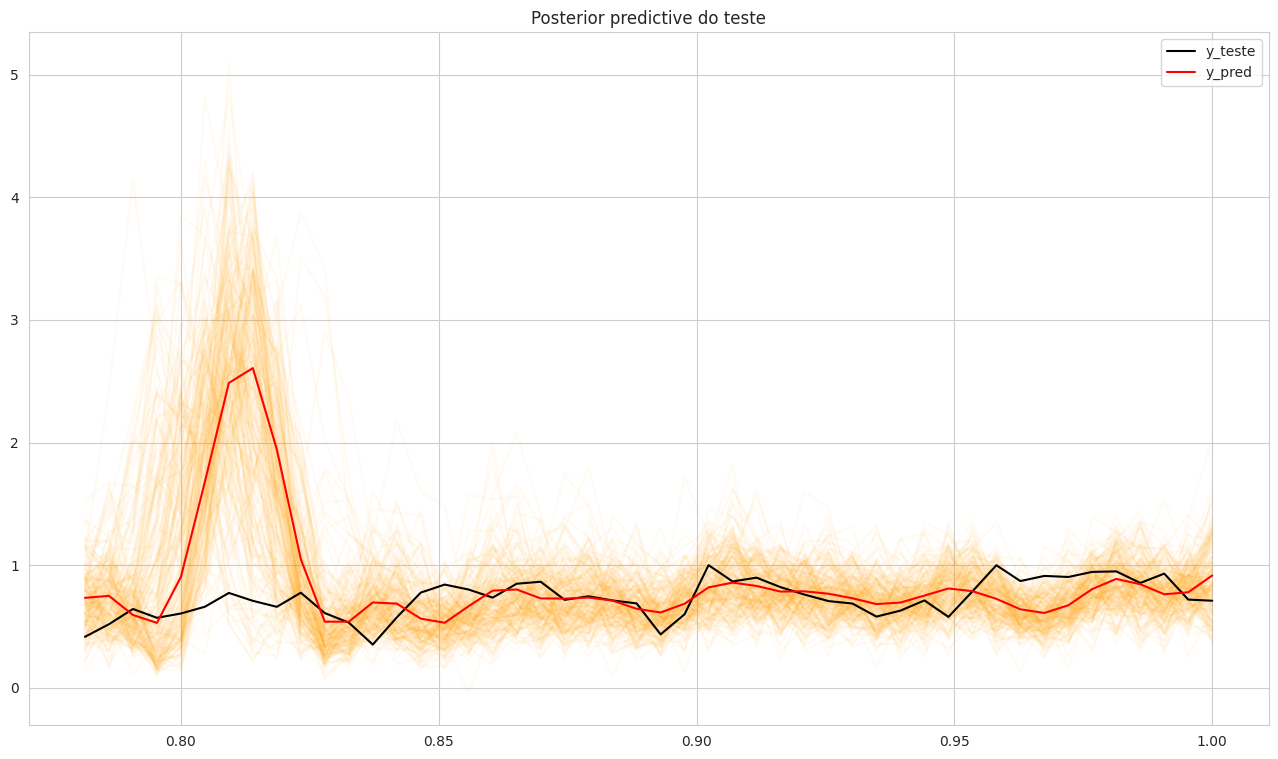

In [200]:
# Visualização das Previsões a Posteriori
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(
    x_teste,
    az.extract_dataset(trace_post_teste, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
sns.lineplot(x=x_teste.flatten(), y=y_pred.flatten(), color="red", label='y_pred', ax=ax)
ax.set_title("Posterior predictive do teste")

# Predição pelo Prophet FFT para 2023

In [201]:
# Geração de novos pontos de dados (meses adicionais)
more_months = 12
passo = 1/(max_month-min_month)
new_points = np.arange(1+passo , 1 + (more_months+1) * passo, passo)
#np.linspace(1+passo, y, int((y - x) / p) + 1)
new_points

array([1.00465116, 1.00930233, 1.01395349, 1.01860465, 1.02325581,
       1.02790698, 1.03255814, 1.0372093 , 1.04186047, 1.04651163,
       1.05116279, 1.05581395])

In [202]:
# Definição das Variáveis para Novos Pontos de Dados
vars = {}
vars["X"] = new_points
vars["y"] = np.zeros(len(new_points),)
vars["f_f"] = get_fourier(len(new_points),7).values

In [203]:
# Amostragem Posterior Preditiva
with prophet_p:
  pm.set_data(vars)
  trace_post_p_m = pm.sample_posterior_predictive(trace_p_p)

In [204]:
# Cálculo das Médias das Previsões
likelihood_values = trace_post_p_m.posterior_predictive["likelihood"].values
mean_likelihood = np.mean(likelihood_values, axis=(0, 1))
mean_likelihood

array([0.89338493, 1.60383973, 1.5186367 , 0.80851124, 0.88648689,
       0.8316634 , 0.86009425, 0.85865802, 0.75626372, 0.73506198,
       0.91503268, 0.9294212 ])

In [205]:
# Amostragem posterior preditiva
trace_post_p_m

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

<ipython-input-206-32ccffc51693>:6: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],


<Axes: title={'center': 'Posterior predictive'}>

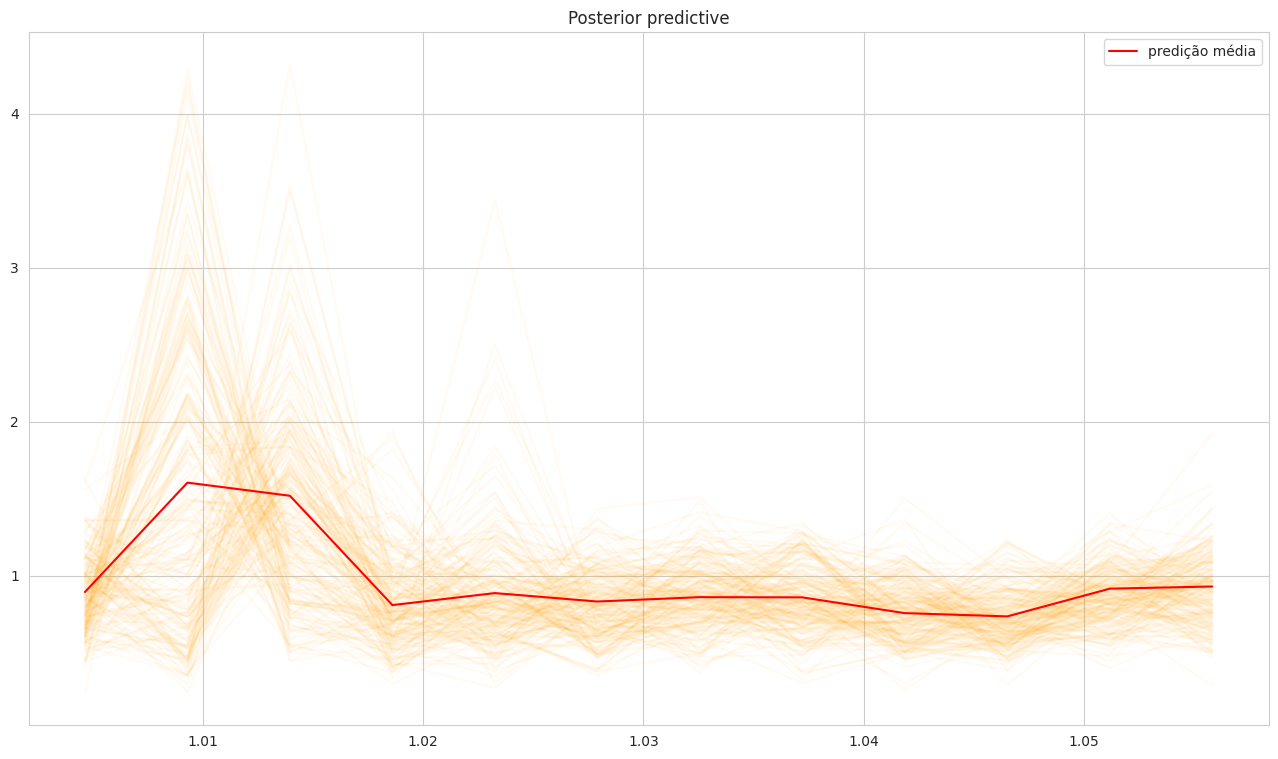

In [206]:
# Visualização das Previsões Anteriores e Novas
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(
    vars['X'],
    az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05,
)
ax.set_title("Posterior predictive")
sns.lineplot(x=vars['X'].flatten(), y=mean_likelihood.flatten(), color="red", label='predição média', ax=ax)

In [207]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
pred_std = mean_likelihood * (maximo_mov - minimo_mov) + minimo_mov
pred_std

array([14038152.49003136, 21552959.02654373, 20651727.37757361,
       13140404.49986063, 13965188.78387079, 13385295.50104792,
       13686021.68203716, 13670830.04286583, 12587758.49526684,
       12363497.99849613, 14267130.62741798, 14419324.65377679])

In [208]:
min_month = original.index.min()
max_month = original.index.max()
data_pred_std = (new_points * int(max_month-min_month) + min_month).astype(int)
data_pred_std

array([216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227])

# Comparando os dados de 2023 Previstos x Realizados

In [209]:
posterior_df = pd.read_csv('./staging/posterior_ts.csv')
posterior_df.data = pd.to_datetime(posterior_df.data)

In [210]:
linear_df = pd.read_csv('./staging/linear_reg.csv')
linear_df['data'] = pd.to_datetime(linear_df['data'])

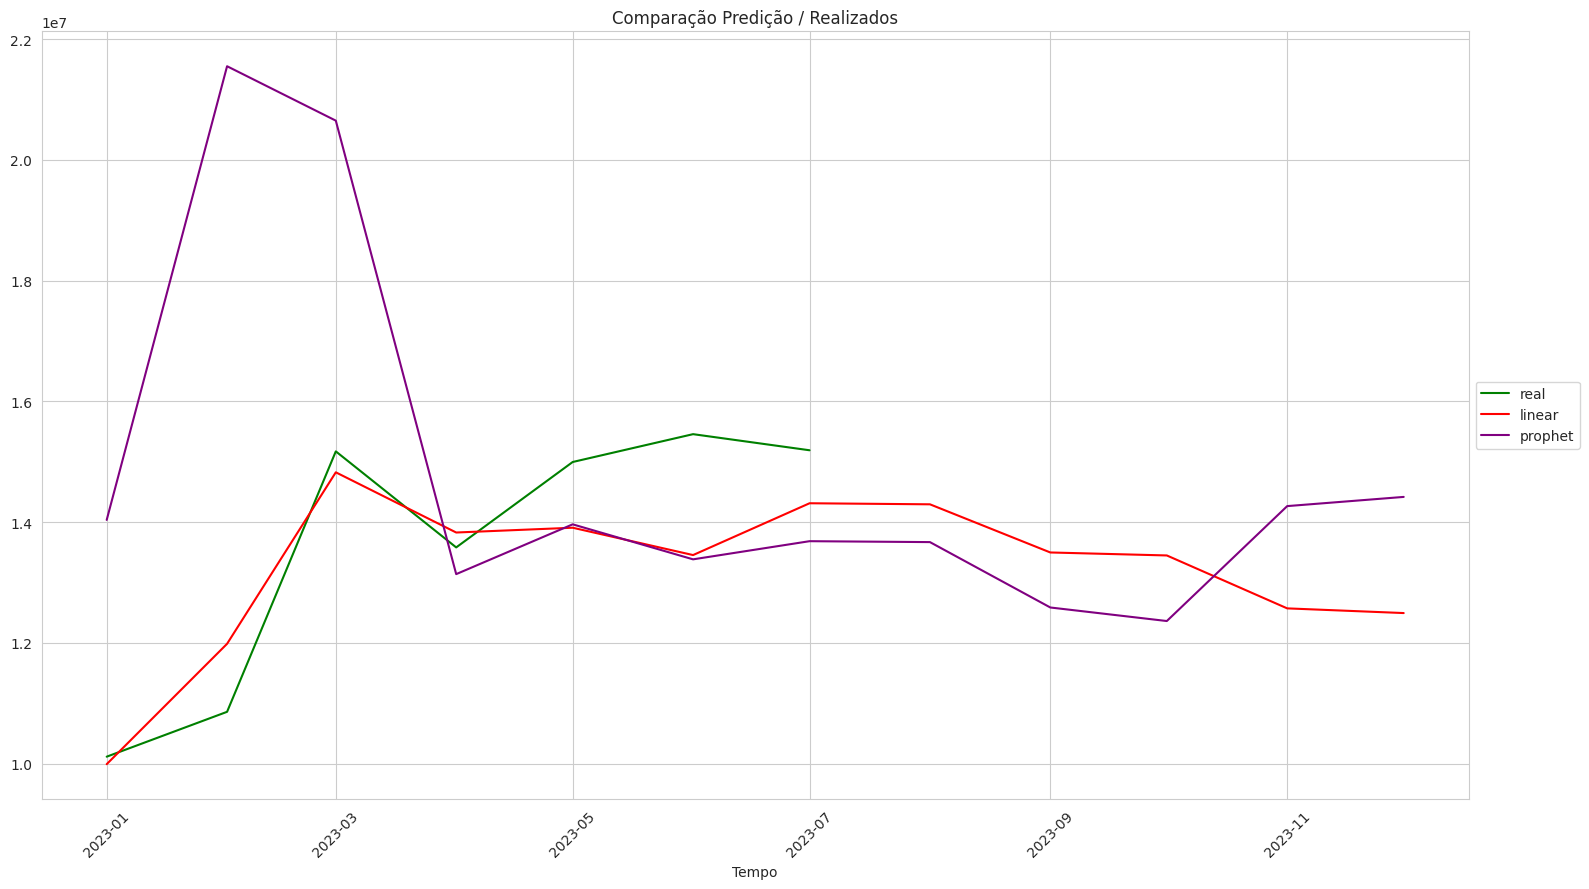

In [211]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,9))

sns.lineplot(x=posterior_df.data, y=posterior_df.porto, label='real', ax=ax, color='g')
sns.lineplot(x=linear_df.data, y=linear_df.porto, label='linear', ax=ax, color='r')
sns.lineplot(x=linear_df.data, y=pred_std, label='prophet', ax=ax, color='purple')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Comparação Predição / Realizados', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Comparação dos modelos

In [212]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))


y_real = posterior_df.porto
y_linear = linear_df.porto[0:7]
y_pht_prd = pred_std[0:7]
print('Erro do Modelo Linear')
print("RMSE:", rmse(y_real, y_linear))
print("MAE:", mae(y_real, y_linear))
print('\nErro do Modelo Prophet FFT multiplicativo')
print("RMSE:", rmse(y_real, y_pht_prd))
print("MAE:", mae(y_real, y_pht_prd))


Erro do Modelo Linear
RMSE: 1030378.989730963
MAE: 830471.2857142857

Erro do Modelo Prophet FFT multiplicativo
RMSE: 4892531.946507645
MAE: 3592427.9181903144
